In [1]:
# Import required libraries for data quality analysis

import pandas as pd      # For data frame manipulation and CSV reading
import numpy as np       # For numerical computations
import matplotlib.pyplot as plt  # For creating visualizations

# Display plots inline in the notebook
%matplotlib inline

# Additional plotting utilities
from matplotlib.backends.backend_pdf import PdfPages  # For saving multiple plots to PDF

In [2]:
def build_dqr_table(df, columns, csv_filename):
    """
    Build and save a Data Quality Report table.
    
    Parameters:
    -----------
    df : pandas.DataFrame
    columns : Index
        Features to include
    csv_filename : str
        Output filename
    
    Returns:
    --------
    pandas.DataFrame
        Complete DQR table
    """
    stats = df[columns].describe().T
    perc_missing = 100 * (df[columns].isnull().sum() / len(df))
    cardinality = df[columns].nunique()
    
    dqr_table = pd.concat([
        stats,
        pd.DataFrame(perc_missing, columns=['%missing']),
        pd.DataFrame(cardinality, columns=['cardinality'])
    ], axis=1)
    
    dqr_table.to_csv(csv_filename, index_label='Feature')
    return dqr_table


print("✓ Helper function loaded successfully")

✓ Helper function loaded successfully


In [3]:
try:
    # Reading from a csv file, into a data frame
    df = pd.read_csv('../data/ppr-group-25200353-train.csv',
                    keep_default_na=True,
                    delimiter=',',
                    skipinitialspace=True)
    
    print(f"✓ Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")

    display(df.head(3))
    
except FileNotFoundError:
    print("ERROR: The file '../data/ppr-group-25200353-train.csv' was not found.")
    print("Please ensure the file is in the current working directory.")
except Exception as e:
    print(f"ERROR: An unexpected error occurred: {e}")

✓ Successfully loaded dataset with 54000 rows and 9 columns


,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,29/02/2016,"APT 14, RUSSELL COURT, FELTRIM RD",Dublin,NaN,"€118,487.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,08/07/2016,"19 PARK VILLAS, DEMESNE RD, DUNDALK",Louth,NaN,"€222,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
2,15/04/2016,"No 2 The Grove, Cahereen Heights, Castleisland",Kerry,NaN,"€123,348.00",No,Yes,New Dwelling house /Apartment,greater than 125 sq metres


In [4]:
# QUESTION: Does the loaded dataset have the expected structure?
# Validate that the dataframe has data and expected columns

print("Dataset Validation Checks:")
print("="*60)

# Check 1: Dataset is not empty
if df.empty:
    print("⚠ WARNING: Dataset is empty!")
else:
    print(f"✓ Dataset contains {df.shape[0]:,} rows")

# Check 2: Check for duplicate rows
duplicate_count = df.duplicated().sum()
if duplicate_count > 0:
    print(f"⚠ WARNING: Found {duplicate_count} duplicate rows")
else:
    print("✓ No duplicate rows found")

# Check 3: Check if all columns are unnamed
unnamed_cols = [col for col in df.columns if 'Unnamed' in str(col)]
if unnamed_cols:
    print(f"⚠ WARNING: Found {len(unnamed_cols)} unnamed columns: {unnamed_cols}")
else:
    print("✓ All columns have names")

# Check 4: Basic column overview
print(f"\n✓ Dataset has {df.shape[1]} columns:")
print(f"  - Column names: {list(df.columns)}")

Dataset Validation Checks:
✓ Dataset contains 54,000 rows
⚠ WARNING: Found 8 duplicate rows
✓ All columns have names

✓ Dataset has 9 columns:
  - Column names: ['Date of Sale (dd/mm/yyyy)', 'Address', 'County', 'Eircode', 'Price (€)', 'Not Full Market Price', 'VAT Exclusive', 'Description of Property', 'Property Size Description']


In [5]:
# QUESTION: What are the dimensions of our dataset? How many rows and columns?
# Check how many rows and columns this dataframe has
print(f"Dataset shape: {df.shape}")
print(f"Number of rows (instances): {df.shape[0]}")
print(f"Number of columns (features): {df.shape[1]}")

Dataset shape: (54000, 9)
Number of rows (instances): 54000
Number of columns (features): 9


In [6]:
# QUESTION: What is the complete information about the dataframe including non-null counts and memory usage?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Date of Sale (dd/mm/yyyy)  54000 non-null  object
 1   Address                    54000 non-null  object
 2   County                     54000 non-null  object
 3   Eircode                    16897 non-null  object
 4   Price (€)                  54000 non-null  object
 5   Not Full Market Price      54000 non-null  object
 6   VAT Exclusive              54000 non-null  object
 7   Description of Property    54000 non-null  object
 8   Property Size Description  2799 non-null   object
dtypes: object(9)
memory usage: 3.7+ MB


### Correcting Feature Data Types

Some features were incorrectly classified. Specifically:
- **Price (€)**: Should be numerical (remove the price formatting)
- **County**: Low cardinality (categorical)
- **Not Full Market Price/VAT Exclusive**: Yes/No options should be categorical
- **Description of Property/Property Size Description**: Low cardinality, suggesting it could be categorical

| Feature | Type Correction |
----------|-----------------|
| Date of Sale (dd/mm/yyyy) | object |
|Address                    | object |
|County                     | object -> categorical |
|Eircode                    | object |
|Price (€)                  | object -> numeric |
|Not Full Market Price      | object -> categorical |
|VAT Exclusive              | object -> categorical |
|Description of Property    | object -> categorical |
|Property Size Description  | object -> categorical |

In [7]:
# Fixing Price ==================================================

try:
    # remove euro symbol
    df['Price (€)'] = df['Price (€)'].str.replace('€', '', regex=False)
    
    # remove commas
    df['Price (€)'] = df['Price (€)'].str.replace(',', '', regex=False)
    
    # convert string to float (numeric)
    df['Price (€)'] = pd.to_numeric(df['Price (€)'])
    print("feature 'Price (€)' corrected.")
except AttributeError:
    print("'Price (€)' is correctly formatted.")
    

# Converting to Categorical ==================================================

df['County'] = df['County'].astype('category')
df['Not Full Market Price'] = df['Not Full Market Price'].astype('category')
df['VAT Exclusive'] = df['VAT Exclusive'].astype('category')
df['Description of Property'] = df['Description of Property'].astype('category')
df['Property Size Description'] = df['Property Size Description'].astype('category')

print("Updated features to be categorical.")


feature 'Price (€)' corrected.
Updated features to be categorical.


In [8]:
# QUESTION: What is the complete information about the dataframe including non-null counts and memory usage?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Date of Sale (dd/mm/yyyy)  54000 non-null  object  
 1   Address                    54000 non-null  object  
 2   County                     54000 non-null  category
 3   Eircode                    16897 non-null  object  
 4   Price (€)                  54000 non-null  float64 
 5   Not Full Market Price      54000 non-null  category
 6   VAT Exclusive              54000 non-null  category
 7   Description of Property    54000 non-null  category
 8   Property Size Description  2799 non-null   category
dtypes: category(5), float64(1), object(3)
memory usage: 1.9+ MB


In [9]:
# QUESTION: Which features are numeric? Extract only numeric columns for separate analysis.
#Keep only the numeric features.
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
numeric_columns

Index(['Price (€)'], dtype='object')

In [10]:
# QUESTION: What do all the categorical features look like together?
#Look at the categorical features only
category_columns = df.select_dtypes(['category']).columns
category_columns

Index(['County', 'Not Full Market Price', 'VAT Exclusive',
       'Description of Property', 'Property Size Description'],
      dtype='object')

In [11]:
# QUESTION: How many unique values (cardinality) does each numeric feature have?

for column in numeric_columns:
    print(f"\nFeature: {column}") 
    print(f"Number of distinct categories: {len(df[column].unique())}")
    print(f"Unique values: {df[column].unique()}")
    


Feature: Price (€)
Number of distinct categories: 6788
Unique values: [118487.   222000.   123348.   ... 352570.37 149981.   530388.  ]


In [12]:
# QUESTION: What are the summary statistics (mean, std, min, max, quartiles) for numeric features?
# Descriptive stats for continuous features
# df.describe() by default only prints stats for the numeric columns int64 and float64.
# Often we need to change the feature data type so it more appropriately reflects whether this is 
# a continuous or a categorical feature.
pd.set_option("display.precision", 2)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price (€),54000.0,327020.43,1.11e+06,5260.0,158590.31,251982.0,365000.0,1.36e+08


In [13]:
df.to_csv('../data/housing-prices.csv')

In [14]:
# Usage:
df_numeric_dqr = build_dqr_table(df, numeric_columns, 
                                  '../data/housing-prices-numeric-features.csv')
display(df_numeric_dqr)

,count,mean,std,min,25%,50%,75%,max,%missing,cardinality
Price (€),54000.0,327020.43,1.11e+06,5260.0,158590.31,251982.0,365000.0,1.36e+08,0.0,6788


In [15]:
# Usage:
df_categorical_dqr = build_dqr_table(df, category_columns, 
                                  '../data/housing-prices-categorical-features.csv')
display(df_categorical_dqr)

,count,unique,top,freq,%missing,cardinality
County,54000,26,Dublin,16577,0.00,26
Not Full Market Price,54000,2,No,51150,0.00,2
VAT Exclusive,54000,2,No,44530,0.00,2
Description of Property,54000,3,Second-Hand Dwelling house /Apartment,44366,0.00,3
Property Size Description,2799,4,greater than or equal to 38 sq metres and less...,2088,94.82,4


## Data Quality Report: Visualisations

In this section we plot histograms and boxplots for numeric features and barplots for categorical features. This is a visual approach to exploring the distribution of values for each feature.

Visualizations complement the statistical tables and help us quickly identify data quality issues:

**Histograms** show the distribution of values. Look for:
- Skewed distributions (most values on one side)
- Outliers (extreme values far from the main distribution)
- Unexpected gaps or clusters

**Box plots** highlight outliers and quartile boundaries. They show:
- The median (line in the box)
- The interquartile range (the box)
- Outliers (points beyond the whiskers)

Below we create these visualizations for the numeric features.

### Example Visualizations

Below we show example plots for specific features to demonstrate interpretation techniques:
- **Income of Policy Holder**: Shows numeric feature visualization using histogram and boxplot
- **Marital Status**: Shows categorical feature visualization using bar plot

After examining individual features, we'll generate histograms for all numeric features at once.

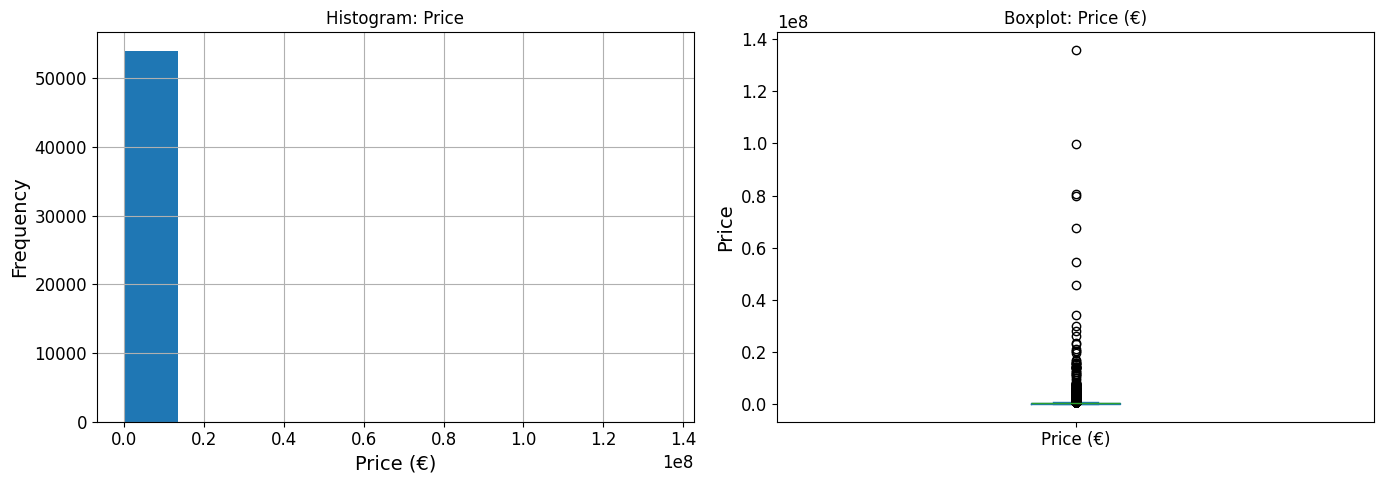

In [35]:
# Create subplots for histogram and boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
df['Price (€)'].hist(ax=axes[0])
axes[0].set_title('Histogram: Price')
axes[0].set_xlabel('Price (€)')
axes[0].set_ylabel('Frequency')

# Boxplot
df['Price (€)'].plot(kind='box', ax=axes[1])
axes[1].set_title('Boxplot: Price (€)')
axes[1].set_ylabel('Price')

plt.tight_layout()
plt.show()

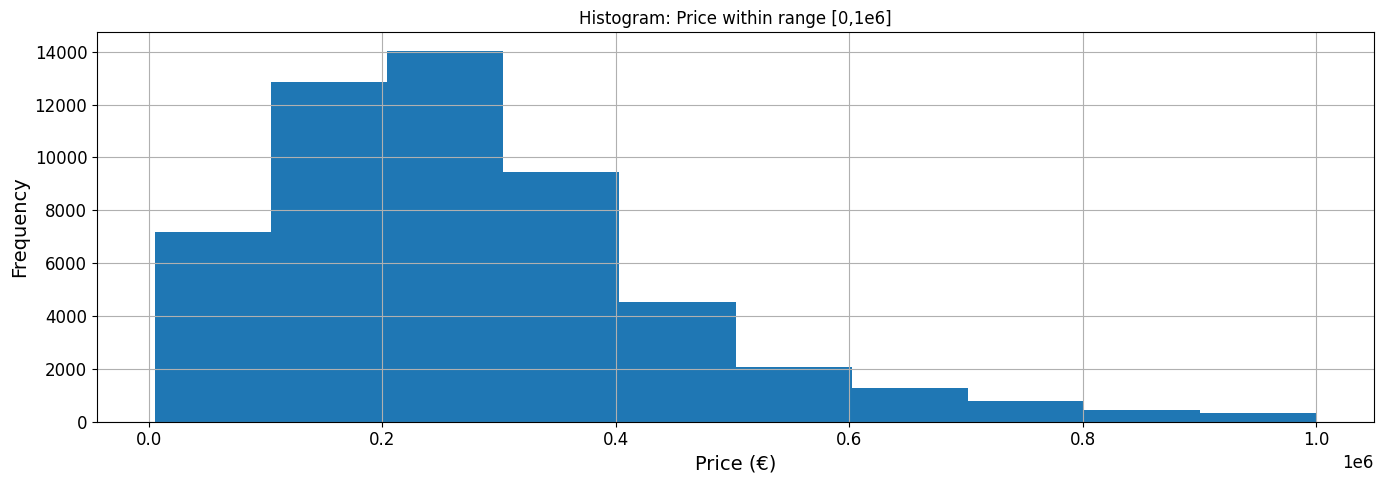

In [34]:
# Create subplots for histogram and boxplot
fig, axes = plt.subplots(1, 1, figsize=(14, 5))

# Histogram
df[df['Price (€)'].between(0, 1000000)].hist(ax=axes)
axes.set_title('Histogram: Price within range [0,1e6]')
axes.set_xlabel('Price (€)')
axes.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Visualizing Categorical Features

**Bar plots** show the frequency distribution of categorical variables. Look for:
- Imbalanced categories (one category dominates)
- Rare categories (categories with very few examples)
- Missing values (shown if `dropna=False`)

These insights help us decide whether to combine categories, remove rare ones, or impute missing values.

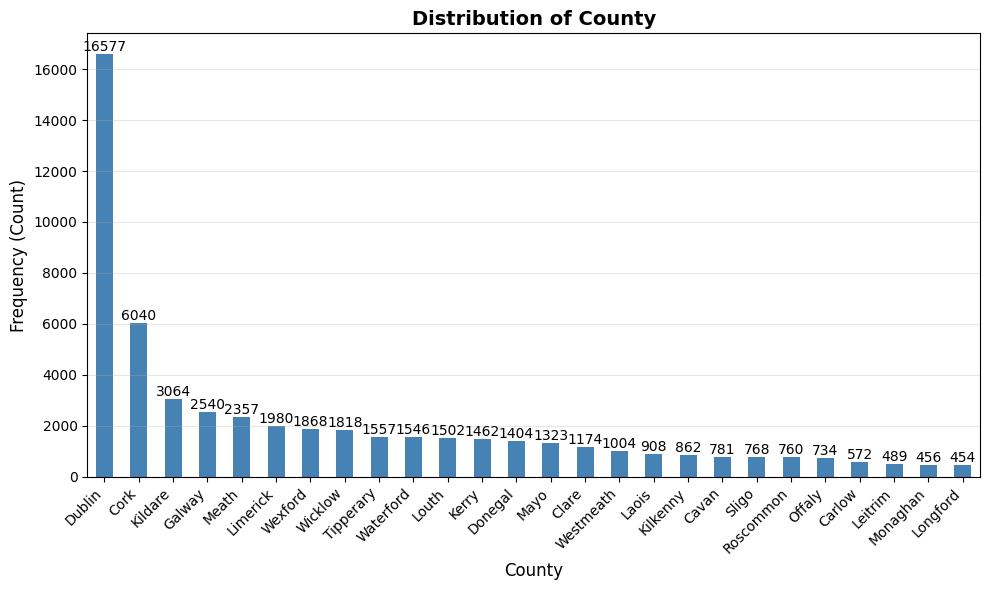

In [17]:
# QUESTION: How are the categories distributed in 'County'? Are any categories rare or heavily dominant?

plt.figure(figsize=(10, 6))
ax = df['County'].value_counts(dropna=False).plot(kind='bar', color='steelblue')
plt.title('Distribution of County', fontsize=14, fontweight='bold')
plt.xlabel('County', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

# PDF pages of all categorical features

In [18]:
# Set plot styling for readability
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

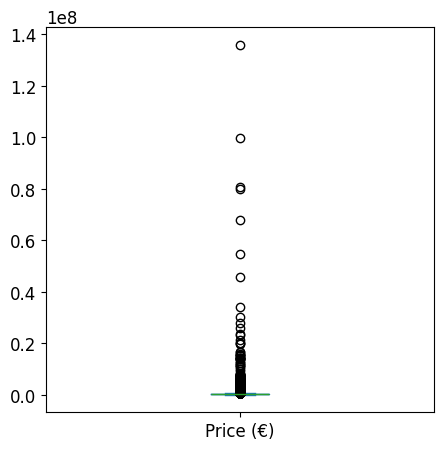

In [19]:
# One boxplot per numeric feature, saved to a single PDF
pp = PdfPages('housing-prices-numerical-features_boxplots.pdf')

for col in numeric_columns:
    f = df[col].plot(kind='box', figsize=(5,5))
    pp.savefig(f.get_figure())
    plt.show()

pp.close()

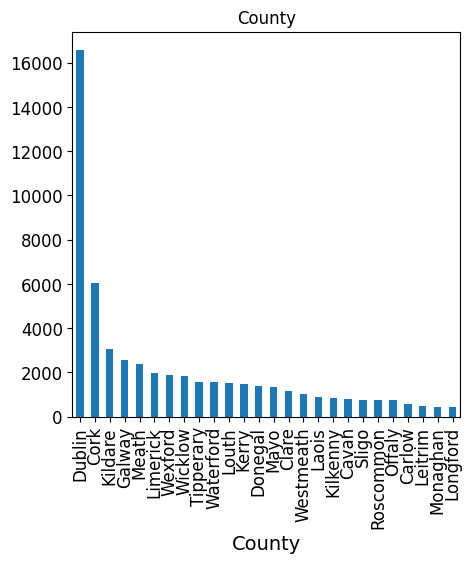

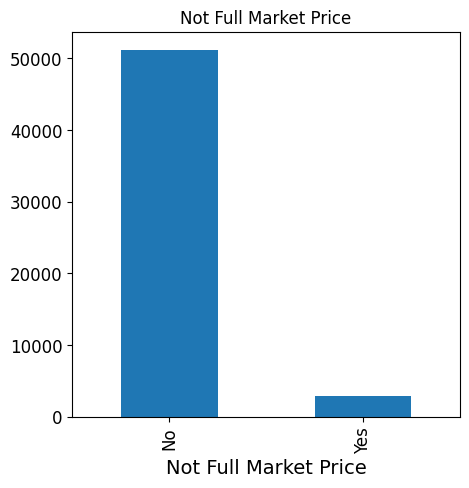

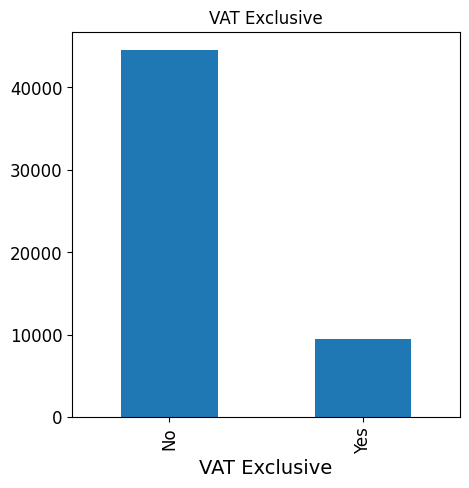

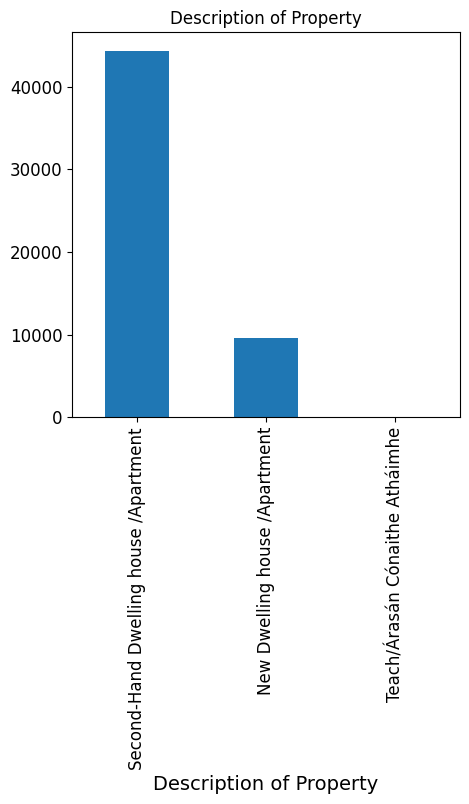

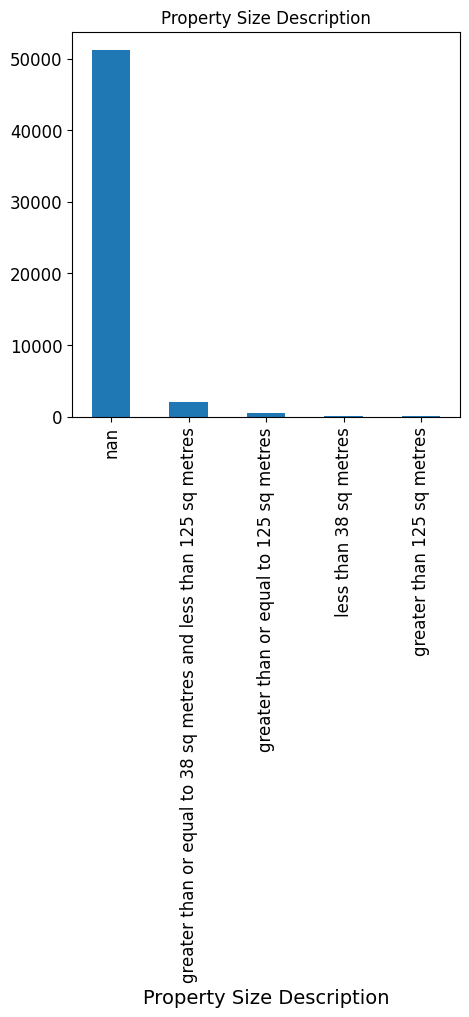

In [20]:
# Bar charts for all categorical features (saved to a single PDF)
# dropna=False keeps missing values visible
pp = PdfPages('housing-prices-categorical-features_barcharts.pdf')

for column in category_columns:
    f = df[column].value_counts(dropna=False).plot(kind='bar', title=column, figsize=(5,5))
    pp.savefig(f.get_figure())
    plt.show()

pp.close()

In [21]:
df[df['Price (€)']==df['Price (€)'].max()]

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
38190,07/12/2022,"Apartment Development, at Castleview, Carriglea",Dublin,NaN,1.36e+08,No,Yes,New Dwelling house /Apartment,NaN
